<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

In [2]:
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from loguru import logger

In [3]:
class Actor(tf.keras.Model):
    def __init__(self, n_state, n_action, alpha, a_low, a_high, exploration_noise) -> None:
        super(Actor, self).__init__()
        self.w_init = tf.keras.initializers.RandomNormal(0, .1)
        self.b_init = tf.keras.initializers.constant(.1)
        self.n_action = n_action
        self.alpha = alpha
        self.loss_fn = tf.keras.losses.sparse_categorical_crossentropy  # -lnx
        self.optimizer_fn = tf.keras.optimizers.Adam(alpha)
        self.activation_fn = lambda x: tf.clip_by_value(tf.random.normal([1], x, exploration_noise), a_low, a_high)  # policy + noise + clip
        self.nn = [
            tf.keras.layers.Dense(
                16, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            # tf.keras.layers.Dense(
            #     16, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            # tf.keras.layers.Dense(
            #     16, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            tf.keras.layers.Dense(
                self.n_action, activation='linear', kernel_initializer=self.w_init, bias_initializer=self.b_init)
        ]

    def call(self, x):
        for layer in self.nn:
            x = layer(x)
        return x

    @tf.function
    def learn(self, actor, critic, state):
        with tf.GradientTape() as tape:
            loss = critic(tf.concat([state, actor(state)], 1))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fn.apply_gradients(zip(grads, self.trainable_variables))

In [4]:
class Critic(tf.keras.Model):
    def __init__(self, n_state, n_action, alpha, gamma) -> None:
        super(Critic, self).__init__()
        self.w_init = tf.keras.initializers.RandomNormal(0, .1)
        self.b_init = tf.keras.initializers.constant(.1)
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.loss_fn = tf.keras.losses.mse
        self.optimizer_fn = tf.keras.optimizers.Adam(self.alpha)
        self.nn = [
            tf.keras.layers.Dense(
                32, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            # tf.keras.layers.Dense(
            #     32, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            # tf.keras.layers.Dense(
            #     32, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            tf.keras.layers.Dense(
                1, activation='linear', kernel_initializer=self.w_init, bias_initializer=self.b_init)
        ]

    def call(self, x):
        for layer in self.nn:
            x = layer(x)
        return x

    @tf.function
    def learn(self, target_actor, target_critic, state, action, reward, state_):
        with tf.GradientTape() as tape:
            target_q = tf.stop_gradient(target_critic(tf.concat([state_, target_actor(state_)], 1)))
            y_true = reward + self.gamma * target_q
            y_pred = self(tf.concat([state, action], 1))  # action = actor(state)
            loss = self.loss_fn(y_true, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fn.apply_gradients(zip(grads, self.trainable_variables))

In [5]:
class ReplayMemory():
    def __init__(self, N: int) -> None:
        self.N = N
        self.q = deque(maxlen=N)

    def save_experience(self, s, a: float, r: float, s_) -> None:
        # if isinstance(s, np.ndarray):  # hash
        #     s = s.tolist()
        # if isinstance(s_, np.ndarray):
        #     s_ = s_.tolist()
        experience = [s, a, r, s_]
        # exist = experience in self.q
        # if not exist:
        #     self.q.append(experience)
        self.q.append(experience)


    def sample_experience(self, batch_size: int):
        minibatch = random.sample(self.q, batch_size)
        s, a, r, s_ = map(np.stack, zip(*minibatch))
        return s, a, r, s_

    def __len__(self) -> int:
        return len(self.q)

In [6]:
class DDPG:
    def __init__(
        self,
        state_n: int,
        action_n: int,
        a_low: float,
        a_high: float,
        alpha_q: float = 0.002,
        alpha_p: float = 0.001,
        gamma: float = 0.9,
        tau: float = 0.01,
        exploration_noise: float = 3,
        memory_size: int = 10000,
        batch_size: int = 32,
    ) -> None:
        self.online_actor = Actor(state_n, action_n, alpha_p, a_low, a_high, exploration_noise)
        self.online_critic = Critic(state_n, action_n, alpha_q, gamma)
        self.target_actor = Actor(state_n, action_n, alpha_p, a_low, a_high, exploration_noise)
        self.target_critic = Critic(state_n, action_n, alpha_q, gamma)
        self.replay_buffer = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.tau = tau
        self.exploration_noise = exploration_noise

    def sample(self, state):
        def online_actor_sample(state):
            state = tf.constant(tf.expand_dims(state, 0))
            op = self.online_actor(state)[0]
            action = tf.random.normal([1], op, self.exploration_noise).numpy()
            return action
        return online_actor_sample(state)

    def learn(self):
        state, action, reward, state_ = self.replay_buffer.sample_experience(
            self.batch_size)
        state = tf.cast(tf.constant(state), dtype=tf.float32)
        action = tf.cast(tf.constant(action), dtype=tf.float32)
        reward = tf.cast(tf.constant(reward), dtype=tf.float32)
        state_ = tf.cast(tf.constant(state_), dtype=tf.float32)
        # online actor & critic
        self.online_critic.learn(self.target_actor, self.target_critic, state, action, reward, state_)
        self.online_actor.learn(self.online_actor, self.online_critic, state)
        # target actor & critic
        for o, t in zip(self.online_actor.trainable_variables + self.online_critic.trainable_variables, self.target_actor.trainable_variables + self.target_critic.trainable_variables):
            t.assign(self.tau * o + (1 - self.tau) * t)
        self.exploration_noise *= .995
        
    def save_experience(self, state, action, reward, state_):
        self.replay_buffer.save_experience(state, action, reward, state_)

    def save_model(self) -> None:
        self.online_actor.save('online_actor')
        self.online_critic.save('online_critic')
        self.target_actor.save('target_actor')
        self.target_critic.save('target_critic')

    def load_model(self) -> None:
        self.online_actor = tf.keras.models.load_model('online_actor', compile=False)
        self.online_critic = tf.keras.models.load_model('online_critic', compile=False)
        self.target_actor = tf.keras.models.load_model('target_actor', compile=False)
        self.target_critic = tf.keras.models.load_model('target_critic', compile=False)

In [7]:
def run_episode(env: gym.Wrapper, agent: DDPG, training: bool, render: bool = False, max_steps: int = 200) -> float:
    state = env.reset()
    score = 0
    for step in range(max_steps): # done 永远为 False
        if render:
            env.render()
        action = agent.sample(state)
        state_, reward, done, info = env.step(action)
        agent.save_experience(state, action, reward, state_)
        score += reward
        if training:
            agent.learn()
        state = state_
    return score

In [8]:
def warm(env: gym.Wrapper, agent: DDPG, warm_steps: int = 64) -> None:
    for warm_step in range(warm_steps):
        run_episode(env, agent, training=False)


def train(env: gym.Wrapper, agent: DDPG) -> None:
    score_result = []
    max_score = 0
    for episode in range(200):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
            agent.save_model()
        elif score == max_score:
            logger.info('Episode {}: Best score {}'.format(episode, score))
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))
    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()


def play(env: gym.Wrapper, agent: DDPG) -> None:
    score_result = []
    # agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))
    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-14 22:24:31.112 | INFO     | __main__:train:20 - Episode 0: score -1264.4566877097584
2021-10-14 22:25:22.524 | INFO     | __main__:train:20 - Episode 50: score -1459.4060911772926
2021-10-14 22:26:14.084 | INFO     | __main__:train:20 - Episode 100: score -1379.2937531179823
2021-10-14 22:27:06.452 | INFO     | __main__:train:20 - Episode 150: score -1156.7269789873537


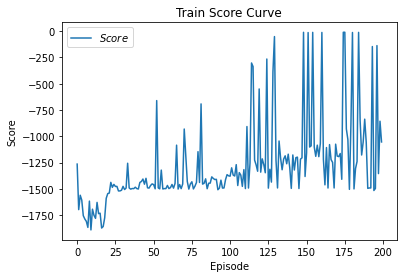

2021-10-14 22:27:58.125 | INFO     | __main__:play:35 - Round 0: score: -1201.8980137786125
2021-10-14 22:27:58.379 | INFO     | __main__:play:35 - Round 1: score: -938.7783919849645
2021-10-14 22:27:58.641 | INFO     | __main__:play:35 - Round 2: score: -840.3975914269596
2021-10-14 22:27:58.889 | INFO     | __main__:play:35 - Round 3: score: -14.64117078059007
2021-10-14 22:27:59.117 | INFO     | __main__:play:35 - Round 4: score: -1240.5342953616323


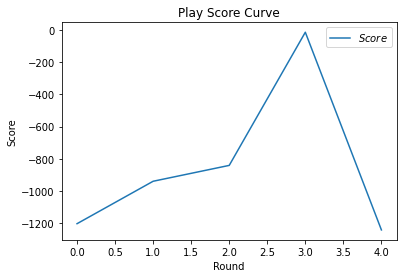

In [9]:
if __name__ == '__main__':
    env = gym.make('Pendulum-v0')
    agent = DDPG(env.observation_space.shape[0], env.action_space.shape[0], env.action_space.low[0], env.action_space.high[0])
    warm(env, agent)
    train(env, agent)
    play(env, agent)